# Introduction

One of the interesting and important things to consider is the mask of the returned data (if applicable). SCRIP will always return an object of the MaskedArray class, however, it need not have a mask associated with it. 

Conversion between the ocean and the atmospheric grid is as one would expect. However, conversion from an ocean to the LL1 grid is not what one would expect in the sense that the output grid does not have a mask aassociated with it. This is because the LL1 grid that I have constructed and am using does not have a continental mask associated with it. Therefore, it just behaves like an atmospheric grid (like the FV1 which also does not have a mask). In light of this recognition, the conversion behaviour between GX1 and LL1 becomes easier to understand. 

NOTE: An important thing to note is that when SCRIP returns a grid which was obtained from a remapping of a grid which had a mask, then although the output grid does not have a mask, the cells in the output grid, which would have been masked is set to zero. 

In [1]:
%%HTML
<style>
div.prompt {display:none}
</style>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt

In [1]:
import sys, os
import PySCRIP.source as scrip
from PySCRIP.source.config import PySCRIPConfig

In [2]:
fv1data = {'file':'testdata/cesmpifv1mts_cam_mapping_testdata.nc', 'var':'TS'}
gx1data = {'file':'testdata/cesmpifv1mts_pop_mapping_testdata.nc', 'var':'SSH'}

In [3]:
a = PySCRIPConfig()

# Conversions

## FV1 to GX1

In [4]:
ncfile = Dataset(fv1data['file'], "r")
fv1_src_data = ncfile.variables[fv1data['var']][:,:]
ncfile.close()

gx1_dest_data = scrip.remap(fv1_src_data, a.mapFile('cesmpifv1mts', 'conservative','fv1', 'gx1'))

In [5]:
print type(fv1_src_data)
print type(gx1_dest_data)

<type 'numpy.ndarray'>
<class 'numpy.ma.core.MaskedArray'>


In [6]:
print gx1_dest_data.mask

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


The stats function prints some statistics of the distribution of data between the input and the output grids, and plots histograms. 

NOTE: The statistics can be misleading when masks are involved! Because masks, well... mask values, so distrubutions will be different.

In [7]:
def stats(arr1, arr2, range=None):
    print("Array shapes:  {0}     {1}".format(arr1.squeeze().shape, arr2.shape))
    print("Minimum     :  {0}     {1}".format(arr1.min(), arr2.min()))
    print("Mean        :  {0}     {1}".format(arr1.mean(), arr2.mean()))    
    print("Maximum     :  {0}     {1}".format(arr1.max(), arr2.max()))    
    print("Std         :  {0}     {1}".format(arr1.std(), arr2.std()))
    
    fig, (ax1, ax2) = plt.subplots(figsize=(14,5), nrows=1, ncols=2)
    ax1.hist(arr1.flatten(), bins=30, range=range, normed=True)
    ax1.set_title("Source Array")

    ax2.hist(arr2.flatten(), bins=30, range=range, normed=True)
    ax2.set_title("Destination Array")
    plt.show()


In [8]:
stats(fv1_src_data, gx1_dest_data, range=(200, 320))

Array shapes:  (192, 288)     (384, 320)
Minimum     :  213.01789856     237.130834706
Mean        :  275.515106201     287.723485009
Maximum     :  309.005615234     303.754011366
Std         :  23.6378955841     16.025623308


NameError: global name 'plt' is not defined

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

NameError: name 'plt' is not defined

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_dest_data))
plt.colorbar()
plt.title("Destination data")
plt.show()

NameError: name 'plt' is not defined

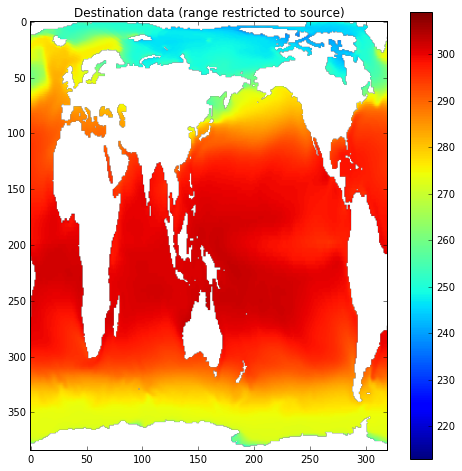

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_dest_data), vmin=fv1_src_data.min(), vmax=fv1_src_data.max())
plt.colorbar()
plt.title("Destination data (range restricted to source)")
plt.show()

## GX1 to FV1

In [13]:
ncfile = Dataset(gx1data['file'], "r")
gx1_src_data = ncfile.variables[gx1data['var']][:,:]
ncfile.close()


fv1_dest_data = scrip.remap(gx1_src_data, a.mapFile('cesmpifv1mts', 'conservative','gx1', 'fv1'))
# fv1_dest_data[np.where(fv1_dest_data == 0) ] = np.nan
# gx1_src_data[np.where(gx1_src_data == 0) ] = np.nan

ValueError: failed to initialize intent(inout) array -- expected elsize=4 but got 8

Here we see that the FV1 data that is returned by SCRIP is of the class maskedarray, this is what we would expect since the input data is masked. 

In [14]:
print type(gx1_src_data)
print type(fv1_dest_data)

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


In [34]:
print gx1_src_data.mask

[[[ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  ..., 
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]]]


However, since FV1 is an atmosphere grid which has no mask associated with it, the mask attribute is actually just a boolean and is False, rather than the 2D mask that we might have expected. 

In [35]:
print fv1_dest_data.mask

False


Array shapes:  (384, 320)     (192, 288)
Minimum     :  -237.680648804     -236.318649992
Mean        :  -9.51669966775     -16.6751322005
Maximum     :  121.562255859     119.597963177
Std         :  82.961865504     71.4357867027


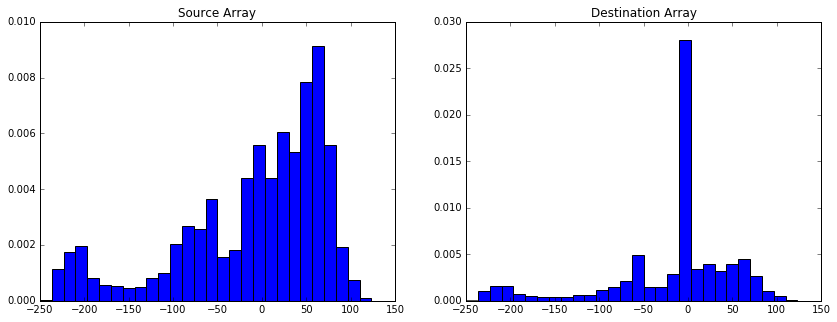

In [15]:
stats(gx1_src_data, fv1_dest_data, range=(-250,150))

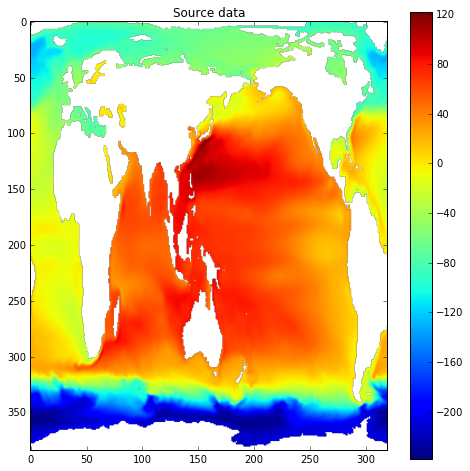

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

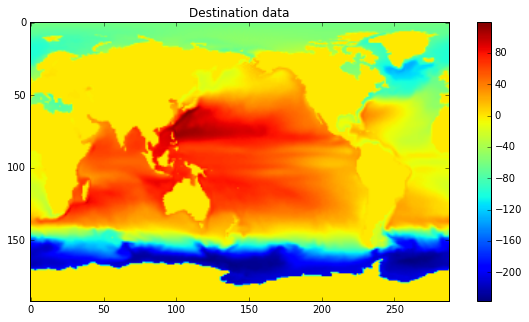

In [17]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_dest_data))
plt.colorbar()
plt.title("Destination data")
plt.show()

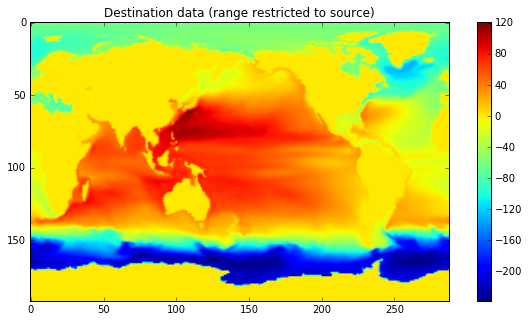

In [18]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_dest_data), vmin=gx1_src_data.min(), vmax=gx1_src_data.max())
plt.colorbar()
plt.title("Destination data (range restricted to source)")
plt.show()

In [20]:
gx1_src_data.mask

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]], dtype=bool)

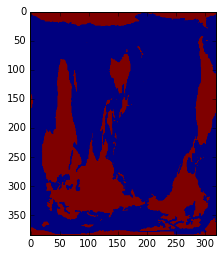

In [21]:
plt.figure()
plt.imshow(gx1_src_data.mask.squeeze().astype('f'))
plt.show()

## FV1 to LL1

In [22]:
ll1_dest_data_from_fv1 = scrip.remap(fv1_src_data, a.mapFile('cesmpifv1mts', 'conservative','fv1', 'll1'))

We see here that SCRIP again returns an array of the MaskedArray class

In [23]:
print type(fv1_src_data)
print type(ll1_dest_data_from_fv1)

<type 'numpy.ndarray'>
<class 'numpy.ma.core.MaskedArray'>


But, since there is no mask associated with the data (we are working with atmospheric data which will not have a mask on any atomospheric grid), the mask attribute is a boolean value and is False. 

In [25]:
print ll1_dest_data_from_fv1.mask

False


Array shapes:  (192, 288)     (180, 360)
Minimum     :  213.01789856     213.431956723
Mean        :  275.515106201     275.725707132
Maximum     :  309.005615234     308.67081473
Std         :  23.6378955841     23.486790569


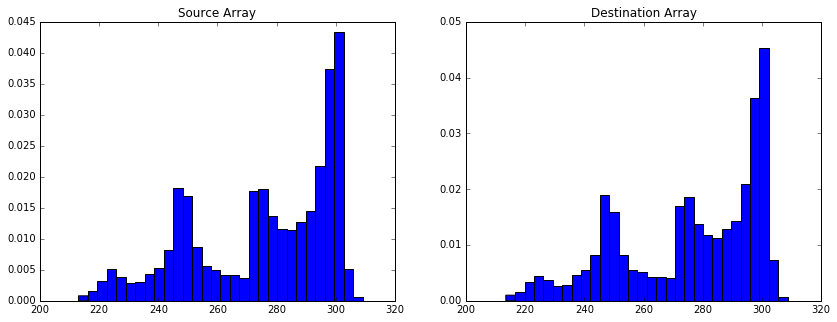

In [26]:
stats(fv1_src_data, ll1_dest_data_from_fv1)

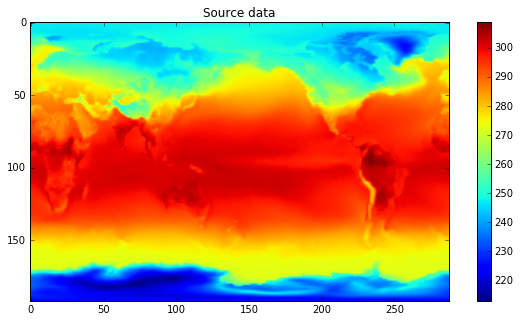

In [27]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(fv1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

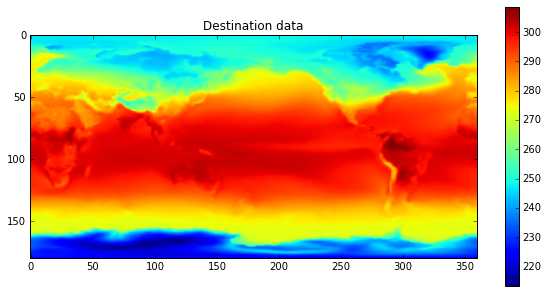

In [28]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(ll1_dest_data_from_fv1))
plt.colorbar()
plt.title("Destination data")
plt.show()

## GX1 to LL1

In [36]:
ll1_dest_data_from_gx1 = scrip.remap(gx1_src_data, a.mapFile('cesmpifv1mts', 'conservative','gx1', 'll1'))
# ll1_dest_data_from_gx1 = np.ma.MaskedArray(ll1_dest_data_from_gx1, mask=(ll1_dest_data_from_gx1 == 0))

This is an interesting case. The input data is clearly a masked array, and as usual SCRIP returns a MaskedArray class. But the returned data does not actually have a mask! 

In [42]:
print type(gx1_src_data)
print type(ll1_dest_data_from_gx1)
print ll1_dest_data_from_gx1.mask

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
False


Array shapes:  (384, 320)     (180, 360)
Minimum     :  -237.680648804     -236.352079246
Mean        :  -9.51669966775     -17.7506201573
Maximum     :  121.562255859     119.508562716
Std         :  82.961865504     73.3857710259


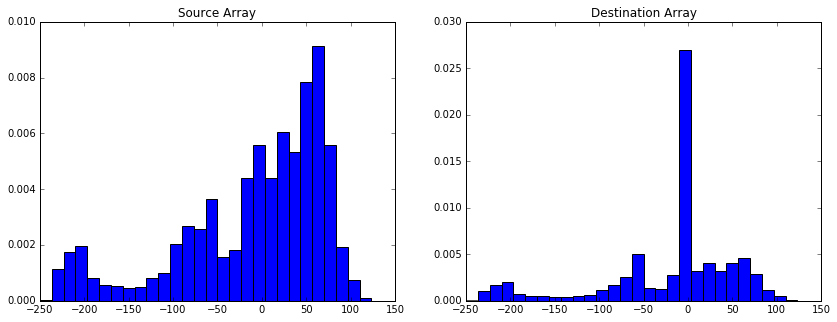

In [39]:
stats(gx1_src_data, ll1_dest_data_from_gx1, range=(-250,150))

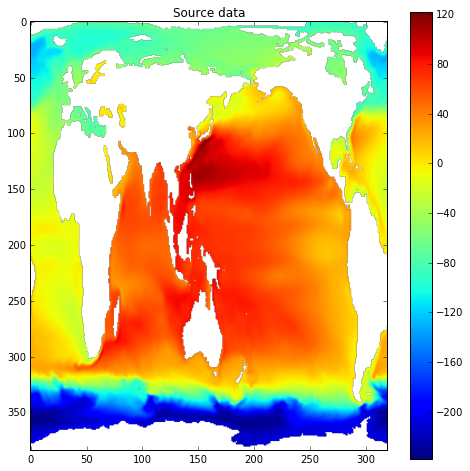

In [40]:
plt.figure(figsize=(8,8))
plt.imshow(np.flipud(gx1_src_data.squeeze()))
plt.colorbar()
plt.title("Source data")
plt.show()

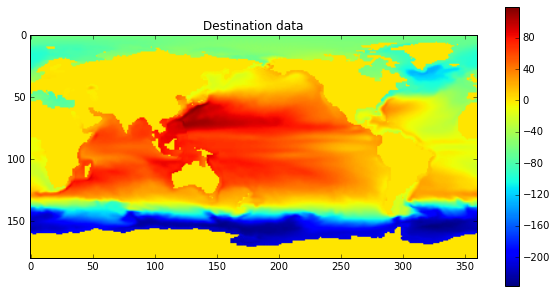

In [41]:
plt.figure(figsize=(10,5))
plt.imshow(np.flipud(ll1_dest_data_from_gx1))
plt.colorbar()
plt.title("Destination data")
plt.show()

In [43]:
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,resolution='c')

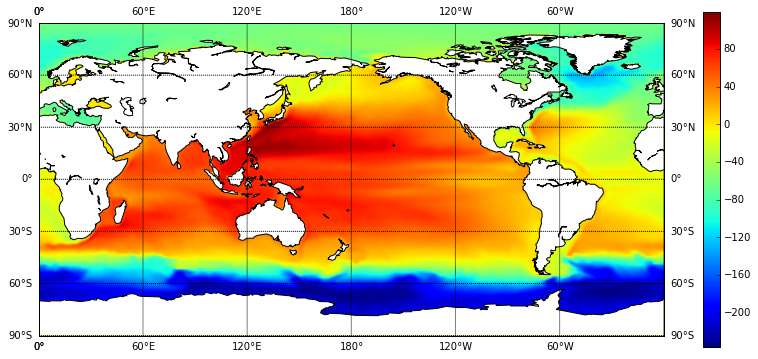

In [44]:
plt.figure(figsize=(14,6))
m.imshow(ll1_dest_data_from_gx1.data)
m.drawcoastlines()
m.fillcontinents(color='white')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.), labels=[True, True, False, False])
m.drawmeridians(np.arange(-180.,181.,60.), labels=[False, False, True, True])
m.drawmapboundary()
plt.colorbar()